In [1]:
import numpy as np
import roboticstoolbox as rtb
from spatialmath import SE3, SO3
from scipy.interpolate import CubicSpline
from roboticstoolbox.backends.swift import Swift
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from spatialgeometry import Cuboid
import random

# envirnoment things

In [2]:
env = Swift()

env.launch(realtime=True, comms="rtc")

panda = rtb.models.Panda()

# Define home configuration (ready pose, 7 joint angles in radians)
q_home = np.array([0, -np.pi/4, 0, -3*np.pi/4, 0, np.pi/2, np.pi/4])

env.add(panda)

bucket_positions = [
    (0.30, -0.50),  
    (0.55, -0.50),  
    (0.30, 0.50),   
    (0.55, 0.50),   
]

# Estrai X e Y
bucket_x = [pos[0] for pos in bucket_positions]
bucket_y = [pos[1] for pos in bucket_positions]

# Calcola i limiti con margine
margin = 0.1
terrain_bounds = {
    "x_min": min(bucket_x) - margin,  # 0.30 - 0.1 = 0.20
    "x_max": max(bucket_x) + margin,  # 0.55 + 0.1 = 0.65
    "y_min": min(bucket_y) - margin,  # -0.50 - 0.1 = -0.60
    "y_max": max(bucket_y) + margin,  # 0.50 + 0.1 = 0.60
}

print(f"[INFO] Terrain bounds (from bucket positions):")
print(f"  X: [{terrain_bounds['x_min']:.2f}, {terrain_bounds['x_max']:.2f}]")
print(f"  Y: [{terrain_bounds['y_min']:.2f}, {terrain_bounds['y_max']:.2f}]")

# Create a colored plane to represent the reachable terrain
terrain = Cuboid(
    [terrain_bounds['x_max'] - terrain_bounds['x_min'], 
     terrain_bounds['y_max'] - terrain_bounds['y_min'], 
     0.001],  
    pose=SE3((terrain_bounds['x_min'] + terrain_bounds['x_max']) / 2, 
             (terrain_bounds['y_min'] + terrain_bounds['y_max']) / 2, 
             0),
    color=[0.5, 0.5, 0.5, 0.3]
)

env.add(terrain)


[INFO] Terrain bounds (from bucket positions):
  X: [0.20, 0.65]
  Y: [-0.60, 0.60]


1

## Objects in the environment

### cubi

In [3]:
# Define cube dimensions and positions
cube_size = 0.06  
cube_height = cube_size
cube_center_z = cube_size / 2  

# Height for picking: top of the cube
pick_z = cube_center_z + cube_height / 2  

# Define pick and place positions for cubes
objects = {
    'red':    (np.array([0.5,  0.25, pick_z]), np.array([0.25, -0.35, pick_z])),
    'blue':   (np.array([0.5,  0.13, pick_z]), np.array([0.25, -0.47, pick_z])),
    'green':  (np.array([0.5,  0.01, pick_z]), np.array([0.25, -0.59, pick_z])),
    'yellow': (np.array([0.5, -0.11, pick_z]), np.array([0.25, -0.71, pick_z])),
}


print(f"Cube size: {cube_size}m")
print(f"Pick/Place height: z={pick_z:.3f}m")
print(f"Objects to sort: {len(objects)}")

for name, (pick, place) in objects.items():
    print(f"  {name}: pick={pick}, place={place}")

# Create visible cube objects in vertical line
bin_red = Cuboid([cube_size, cube_size, cube_size], 
                 pose=SE3(0.5, 0.25, cube_center_z), color=[1, 0, 0, 0.8])      
bin_blue = Cuboid([cube_size, cube_size, cube_size], 
                  pose=SE3(0.5, 0.13, cube_center_z), color=[0, 0, 1, 0.8])     
bin_green = Cuboid([cube_size, cube_size, cube_size], 
                   pose=SE3(0.5, 0.01, cube_center_z), color=[0, 1, 0, 0.8])    
bin_yellow = Cuboid([cube_size, cube_size, cube_size], 
                    pose=SE3(0.5, -0.11, cube_center_z), color=[1, 1, 0, 0.8])  


env.add(bin_red)
env.add(bin_blue)
env.add(bin_green)
env.add(bin_yellow)

print("Objects added to Swift in vertical line")

Cube size: 0.06m
Pick/Place height: z=0.060m
Objects to sort: 4
  red: pick=[0.5  0.25 0.06], place=[ 0.25 -0.35  0.06]
  blue: pick=[0.5  0.13 0.06], place=[ 0.25 -0.47  0.06]
  green: pick=[0.5  0.01 0.06], place=[ 0.25 -0.59  0.06]
  yellow: pick=[ 0.5  -0.11  0.06], place=[ 0.25 -0.71  0.06]
Objects added to Swift in vertical line


### Buckets

#### Fixed buckets

In [4]:
print("\n[BUCKETS] Creating bucket positions at corners...")

# Definisci i colori fissi
color_names = ['red', 'blue', 'green', 'yellow']
color_map = {
    'red': [1, 0, 0, 0.5],
    'blue': [0, 0, 1, 0.5],
    'green': [0, 1, 0, 0.5],
    'yellow': [1, 1, 0, 0.5]
}

# Posizioni fisse
fixed_positions = [
    (0.30, -0.50),  # bottom-left
    (0.55, -0.50),  # bottom-right
    (0.30, 0.50),   # top-left
    (0.55, 0.50),   # top-right
]

# Randomizza l'assegnazione colori -> posizioni
import random
shuffled_colors = color_names.copy()
random.shuffle(shuffled_colors)

corners = {shuffled_colors[i]: fixed_positions[i] for i in range(4)}

# Calcola terrain_bounds in base alle posizioni dei bucket
bucket_positions = list(corners.values())
bucket_x = [pos[0] for pos in bucket_positions]
bucket_y = [pos[1] for pos in bucket_positions]

margin = 0.1
terrain_bounds = {
    "x_min": min(bucket_x) - margin,
    "x_max": max(bucket_x) + margin,
    "y_min": min(bucket_y) - margin,
    "y_max": max(bucket_y) + margin,
}

print(f"[INFO] Terrain bounds (from bucket positions):")
print(f"  X: [{terrain_bounds['x_min']:.2f}, {terrain_bounds['x_max']:.2f}]")
print(f"  Y: [{terrain_bounds['y_min']:.2f}, {terrain_bounds['y_max']:.2f}]")

print(f"\n[INFO] Fixed bucket positions (randomized assignment):")
for color, (x, y) in corners.items():
    print(f"  {color.upper():7s}: ({x:.2f}, {y:.2f})")

# Create plates at fixed corners
plate_height = 0.005  
plate_center_z = plate_height / 2
plate_size = 0.1

plates = {}
plate_objects = {}

print(f"\n[ASSIGNMENT] Creating plates at fixed positions:")

for color, (corner_x, corner_y) in corners.items():
    plate_pos = np.array([corner_x, corner_y, plate_center_z])
    plates[color] = plate_pos
    
    print(f"  {color.upper():7s} at ({corner_x:.2f}, {corner_y:.2f})")
    
    # Usa il colore corretto per il bucket
    plate_color = color_map[color]
    
    # Create plate object
    plate_obj = Cuboid(
        [plate_size, plate_size, plate_height],
        pose=SE3(*plate_pos),
        color=plate_color
    )
    
    env.add(plate_obj)
    plate_objects[color] = plate_obj

print(f"\n[OK] Fixed buckets placed")



[BUCKETS] Creating bucket positions at corners...
[INFO] Terrain bounds (from bucket positions):
  X: [0.20, 0.65]
  Y: [-0.60, 0.60]

[INFO] Fixed bucket positions (randomized assignment):
  RED    : (0.30, -0.50)
  BLUE   : (0.55, -0.50)
  YELLOW : (0.30, 0.50)
  GREEN  : (0.55, 0.50)

[ASSIGNMENT] Creating plates at fixed positions:
  RED     at (0.30, -0.50)
  BLUE    at (0.55, -0.50)
  YELLOW  at (0.30, 0.50)
  GREEN   at (0.55, 0.50)

[OK] Fixed buckets placed


#### Buckets at random

In [5]:
def is_within_bounds(position, bounds, plate_size):
        """Ensure the plate's center does not exceed the bounds."""
        x, y = position[:2]
        return (
            bounds['x_min'] + plate_size / 2 <= x <= bounds['x_max'] - plate_size / 2 and
            bounds['y_min'] + plate_size / 2 <= y <= bounds['y_max'] - plate_size / 2
        )

def generate_unique_positions(num_positions, bounds, min_distance, plate_center_z, plate_size):
    """Generate unique positions for objects within bounds."""
    positions = []
    attempts = 0
    max_attempts = 100  # Prevent infinite loops

    while len(positions) < num_positions and attempts < max_attempts:
        new_pos = np.array([
            random.uniform(bounds['x_min'], bounds['x_max']),
            random.uniform(bounds['y_min'], bounds['y_max']),
            plate_center_z
        ])
        if (
            is_within_bounds(new_pos, bounds, plate_size) and
            all(np.linalg.norm(new_pos[:2] - pos[:2]) >= min_distance for pos in positions)
        ):
            positions.append(new_pos)
        attempts += 1

    if len(positions) < num_positions:
        raise ValueError("Could not generate enough unique positions within the bounds and constraints.")

    return positions

In [6]:
# # Define the size and positions of the plates
# plate_size = 0.1
# plate_height = 0.005  
# plate_center_z = plate_height / 2  # Center of the plate

# # Generate unique positions for the plates
# min_distance_between_plates = plate_size * 1.5  # Ensure plates don't overlap
# plate_positions = generate_unique_positions(4, terrain_bounds, min_distance_between_plates, plate_center_z, plate_size)

# plates = {
#     'red': plate_positions[0],
#     'blue': plate_positions[1],
#     'green': plate_positions[2],
#     'yellow': plate_positions[3],
# }

# # Create visible plate objects in the environment
# plate_red = Cuboid([plate_size, plate_size, plate_height], 
#                    pose=SE3(*plates['red']), color=[1, 0, 0, 0.5])      
# plate_blue = Cuboid([plate_size, plate_size, plate_height], 
#                     pose=SE3(*plates['blue']), color=[0, 0, 1, 0.5])     
# plate_green = Cuboid([plate_size, plate_size, plate_height], 
#                      pose=SE3(*plates['green']), color=[0, 1, 0, 0.5])    
# plate_yellow = Cuboid([plate_size, plate_size, plate_height], 
#                       pose=SE3(*plates['yellow']), color=[1, 1, 0, 0.5])  

# env.add(plate_red)
# env.add(plate_blue)
# env.add(plate_green)
# env.add(plate_yellow)

# print("Plates added to Swift with randomized non-overlapping positions")

### Muri

In [ ]:
# print("\n[WALLS] Creating Smart Box-Collision obstacles...")

# # --- 1. Wall Configuration ---
# num_walls = 3
# wall_length = cube_size * 4  # Increased size (approx 15cm)
# wall_thickness = 0.02          # Increased thickness (2cm)
# wall_height = cube_size * 4

# # Padding settings (in meters)
# safety_padding = 0.01  # Min distance from static objects (1cm)
# wall_padding = 0.05    # Min distance between walls (5cm)

# # --- 2. Index Static Obstacles (Boxes) ---
# # Format: (x_min, x_max, y_min, y_max)
# static_obstacles_boxes = []

# # Add Cubes to collision list
# cube_half_size = cube_size / 2
# for name, (pick, _) in objects.items():
#     cx, cy = pick[0], pick[1]
#     static_obstacles_boxes.append((
#         cx - cube_half_size, cx + cube_half_size, 
#         cy - cube_half_size, cy + cube_half_size
#     ))

# # Add Plates (Buckets) to collision list
# plate_half_size = 0.1 / 2 
# for color, pos in plates.items():
#     px, py = pos[0], pos[1]
#     static_obstacles_boxes.append((
#         px - plate_half_size, px + plate_half_size, 
#         py - plate_half_size, py + plate_half_size
#     ))

# print(f"[INFO] Indexed {len(static_obstacles_boxes)} static objects for collision check.")

# # --- 3. Collision Logic (AABB) ---
# def is_overlapping(box1, box2, padding):
#     """Checks if two rectangles overlap considering a specific padding."""
#     b1_xmin, b1_xmax, b1_ymin, b1_ymax = box1
#     b2_xmin, b2_xmax, b2_ymin, b2_ymax = box2
    
#     # Check if boxes are separated by at least 'padding'
#     if (b1_xmax + padding < b2_xmin) or \
#        (b1_xmin - padding > b2_xmax) or \
#        (b1_ymax + padding < b2_ymin) or \
#        (b1_ymin - padding > b2_ymax):
#         return False # No overlap
#     return True # Collision

# # --- 4. Wall Generation Loop ---
# wall_data = [] # Stores (x, y, is_vertical)
# generated_wall_boxes = [] 

# # Generation area (slightly inside terrain bounds)
# gen_x_min, gen_x_max = terrain_bounds['x_min'] + 0.05, terrain_bounds['x_max'] - 0.05
# gen_y_min, gen_y_max = terrain_bounds['y_min'] + 0.05, terrain_bounds['y_max'] - 0.05

# max_attempts = 5000
# attempts = 0

# while len(wall_data) < num_walls and attempts < max_attempts:
#     attempts += 1
    
#     # 1. Random Pose & Orientation
#     x = np.random.uniform(gen_x_min, gen_x_max)
#     y = np.random.uniform(gen_y_min, gen_y_max)
#     is_vertical = np.random.choice([True, False])
    
#     # 2. Calculate Candidate Box
#     if is_vertical:
#         half_w, half_l = wall_thickness / 2, wall_length / 2
#         candidate_box = (x - half_w, x + half_w, y - half_l, y + half_l)
#     else:
#         half_w, half_l = wall_length / 2, wall_thickness / 2
#         candidate_box = (x - half_w, x + half_w, y - half_l, y + half_l)
        
#     # 3. Check Collisions
#     collision = False
    
#     # A) Check against Static Objects
#     for obs_box in static_obstacles_boxes:
#         if is_overlapping(candidate_box, obs_box, safety_padding):
#             collision = True; break
#     if collision: continue
        
#     # B) Check against Other Walls
#     for wall_box in generated_wall_boxes:
#         if is_overlapping(candidate_box, wall_box, wall_padding): 
#             collision = True; break
#     if collision: continue
    
#     # 4. Valid Position Found
#     wall_data.append((x, y, is_vertical))
#     generated_wall_boxes.append(candidate_box)

# print(f"[RESULT] Generated {len(wall_data)} walls in {attempts} attempts.")

# # --- 5. VISUALIZZAZIONE SU SWIFT ---
# walls_created = 0
# collision_walls = []  # <--- NUOVA LISTA PER LA FISICA

# for (wx, wy, is_vert) in wall_data:
#     wall_z = wall_height / 2 + 0.001
    
#     if is_vert:
#         dims = [wall_thickness, wall_length, wall_height]
#     else:
#         dims = [wall_length, wall_thickness, wall_height]
        
#     wall = Cuboid(
#         dims,
#         pose=SE3(wx, wy, wall_z),
#         color=[0.4, 0.4, 0.4, 0.6]
#     )
#     env.add(wall)
#     collision_walls.append(wall) # <--- SALVIAMO L'OGGETTO QUI
#     walls_created += 1
    
#     ori = "VERT" if is_vert else "HORZ"
#     print(f"  Wall {walls_created}: ({wx:.2f}, {wy:.2f}) [{ori}]")

# # ... (rest del codice di print) ...


[WALLS] Creating Smart Box-Collision obstacles...
[INFO] Indexed 8 static objects for collision check.
[RESULT] Generated 3 walls in 7 attempts.
  Wall 1: (0.57, -0.21) [VERT]
  Wall 2: (0.54, 0.35) [HORZ]
  Wall 3: (0.56, 0.16) [VERT]


# Compute the trajectory that the robot need to do for picking 

## Functions

non molto bene

In [8]:
def compute_ik(panda, position, z_offset=0.0): 
    """Compute IK for a position slightly above the object"""
    target = np.array(position).copy()
    target[2] += z_offset      
    
    pose = SE3(target[0], target[1], target[2]) * SE3.Rx(np.pi)
    
    # result = panda.ikine_LM(pose, q0=q_home, joint_limits=True)
    result = panda.ikine_LM(pose, q0=q_home)

    return result.q, result.success

def make_traj(q_start, q_goal, duration=2.0, n_points=100):
    """Generate a smooth joint-space trajectory from q_start to q_goal."""
    t = np.linspace(0, duration, n_points)          # time vector
    traj = np.zeros((n_points, 7))                  # 7 joints
    
    for i in range(7):
        # cubic spline between start and goal for joint i
        cs = CubicSpline([0, duration], [q_start[i], q_goal[i]])
        traj[:, i] = cs(t)
    
    return traj

## Dictionary with trajectory

In [9]:
approach_height = 0.12 

trajectories = {}

for name, (pick_pos, _) in objects.items():
    # Get the plate position for placing
    place_pos = plates[name]

    # Adjust the cube's center to be above the plate by half the cube's height
    adjusted_place_pos = place_pos.copy()
    adjusted_place_pos[2] = max(plate_center_z + cube_height, adjusted_place_pos[2])

    # IK for approach and contact poses
    
    # Above pick and at pick
    q_pick_above, ok1 = compute_ik(panda, pick_pos, z_offset=approach_height)
    q_pick,       ok2 = compute_ik(panda, pick_pos, z_offset=0.0)
    
    # Above place and at place
    q_place_above, ok3 = compute_ik(panda, adjusted_place_pos, z_offset=approach_height)
    q_place,       ok4 = compute_ik(panda, adjusted_place_pos, z_offset=0.0)
    
    if not (ok1 and ok2 and ok3 and ok4):
        print(f"[ERROR] IK failed for {name}")
        continue

    # Joint-space trajectories for each phase
    traj_home_to_pick_above      = make_traj(q_home,        q_pick_above)
    traj_pick_above_to_pick      = make_traj(q_pick_above,  q_pick)
    traj_pick_to_pick_above      = make_traj(q_pick,        q_pick_above)
    traj_pick_above_to_place_abv = make_traj(q_pick_above,  q_place_above)
    traj_place_abv_to_place      = make_traj(q_place_above, q_place)
    traj_place_to_place_abv      = make_traj(q_place,       q_place_above)
    traj_place_abv_to_home       = make_traj(q_place_above, q_home)

    # Save everything in the dictionary
    trajectories[name] = {
        "home_to_pick_above":       traj_home_to_pick_above,
        "pick_above_to_pick":       traj_pick_above_to_pick,
        "pick_to_pick_above":       traj_pick_to_pick_above,
        "pick_above_to_place_abv":  traj_pick_above_to_place_abv,
        "place_abv_to_place":       traj_place_abv_to_place,
        "place_to_place_abv":       traj_place_to_place_abv,
        "place_abv_to_home":        traj_place_abv_to_home,
    }

## Do the movement

In [10]:
# Map each logical object name to its visual Cuboid in Swift
cube_objs = {
    'red': bin_red,
    'blue': bin_blue,
    'green': bin_green,
    'yellow': bin_yellow
}

### Classic

In [11]:
def execute_pick_and_place(name, sleep_dt=0.02):
    """
    Execute the joint-space trajectories for one object and
    visually attach/detach the cube to the robot gripper.
    """
    cube = cube_objs[name]      # visual cube object
    trajs = trajectories[name]  # all phases for this object

    try:
        # 1) Home -> pick_above (robot approaches, cube stationary)
        for q in trajs["home_to_pick_above"]:
            panda.q = q
            env.step(0.01)
            time.sleep(sleep_dt)

        # 2) pick_above -> pick (descending, cube still stationary) 
        # Calculate the relative transformation hand->cube at the end
        last_q_contact = trajs["pick_above_to_pick"][-1]
        for q in trajs["pick_above_to_pick"]:
            panda.q = q
            env.step(0.01)
            time.sleep(sleep_dt)

        # Pose of the hand and cube at the moment of "contact"
        T_ee_contact   = panda.fkine(last_q_contact)  # end-effector pose at contact
        T_cube_contact = cube.T                       # cube pose on the table
        T_rel = T_ee_contact.inv() * T_cube_contact  # rigid transform hand -> cube

        # 3) pick -> pick_above (cube ATTACHED to the gripper) 
        for q in trajs["pick_to_pick_above"]:
            panda.q = q
            T_ee = panda.fkine(q)
            cube.T = T_ee * T_rel                    # cube follows the hand rigidly
            env.step(0.01)
            time.sleep(sleep_dt)

        # 4) pick_above -> place_above (transport in air with cube attached)
        for q in trajs["pick_above_to_place_abv"]:
            panda.q = q
            T_ee = panda.fkine(q)
            cube.T = T_ee * T_rel
            env.step(0.01)
            time.sleep(sleep_dt)

        # 5) place_above -> place (descending to place the cube)
        last_q_place = trajs["place_abv_to_place"][-1]
        for q in trajs["place_abv_to_place"]:
            panda.q = q
            T_ee = panda.fkine(q)
            cube.T = T_ee * T_rel
            env.step(0.01)
            time.sleep(sleep_dt)

        # Force the cube exactly into the place position
        place_pos = plates[name]  # Use the plate's position 
        cube.T = SE3(place_pos[0], place_pos[1], cube_center_z)

        # 6) place -> place_above (gripper rises, cube STAYS on the table) 
        for q in trajs["place_to_place_abv"]:
            panda.q = q
            # Do not update cube.T: the cube stays where we left it
            env.step(0.01)
            time.sleep(sleep_dt)

        # 7) place_above -> home (robot returns to home)
        for q in trajs["place_abv_to_home"]:
            panda.q = q
            env.step(0.01)
            time.sleep(sleep_dt)

    except Exception as e:
        print(f"[ERROR] Failed to execute pick-and-place for {name}: {e}")

In [ ]:
for name in trajectories.keys():
    print(f"[INFO] Executing pick-and-place for {name}")
    execute_pick_and_place(name, sleep_dt=0.0005)

### Collision

In [ ]:
# def execute_pick_and_place_safe(name, panda, env, collision_walls, sleep_dt=0.02):
#     """
#     Esegue il pick and place.
#     Se urta, RI-PERCORRE la strada al contrario per posare il cubo e poi torna a Home.
#     """
#     cube = cube_objs[name]      
#     trajs = trajectories[name]  
    
#     # Recuperiamo la posizione iniziale (Pick)
#     start_pick_pos = objects[name][0] 
    
#     # Ricalcoliamo i punti chiave per il "ritorno a casa" del cubo
#     # Usiamo lo stesso approach_height usato nella generazione (0.12)
#     q_pick_above, _ = compute_ik(panda, start_pick_pos, z_offset=0.12)
#     q_pick, _ = compute_ik(panda, start_pick_pos, z_offset=0.0)

#     sequence = [    
#         ("home_to_pick_above", False),
#         ("pick_above_to_pick", False),
#         ("pick_to_pick_above", True),
#         ("pick_above_to_place_abv", True),
#         ("place_abv_to_place", True),
#         ("place_to_place_abv", False),
#         ("place_abv_to_home", False)
#     ]

#     print(f"[START] Moving for {name}...")

#     is_attached = False
#     # Memorizziamo la trasformazione relativa (Mano -> Cubo)
#     T_rel = SE3() 

#     for phase_name, should_attach in sequence:
        
#         # --- GESTIONE PRESA/RILASCIO ---
#         if should_attach and not is_attached:
#             T_ee = panda.fkine(panda.q)
#             T_cube = cube.T
#             T_rel = T_ee.inv() * T_cube
#             is_attached = True
#         elif not should_attach and is_attached:
#             place_pos = plates[name]
#             cube.T = SE3(place_pos[0], place_pos[1], plate_center_z)
#             is_attached = False

#         trajectory_points = trajs[phase_name]
        
#         for q in trajectory_points:
#             # --- 1. CONTROLLO COLLISIONE ---
#             collision_detected = False
#             for wall in collision_walls:
#                 if panda.iscollided(q, wall): 
#                     collision_detected = True
#                     break 
            
#             if collision_detected:
#                 print(f"[COLLISION] HIT WALL during {phase_name}!")
                
#                 # === RECUPERO REALISTICO (Rewind) ===
#                 q_crash = panda.q # Punto dell'incidente
                
#                 if is_attached:
#                     print(f"[RECOVERY] Moving {name} back to START position safely...")
                    
#                     # 1. Dal botto a "Sopra il Pick" (per non strisciare)
#                     traj_back_1 = make_traj(q_crash, q_pick_above, duration=1.5)
#                     # 2. Da "Sopra il Pick" a "Pick" (per posarlo)
#                     traj_back_2 = make_traj(q_pick_above, q_pick, duration=1.0)
                    
#                     # Uniamo le due traiettorie
#                     full_retreat = np.vstack((traj_back_1, traj_back_2))
                    
#                     # Eseguiamo il movimento all'indietro PORTANDO IL CUBO
#                     for q_ret in full_retreat:
#                         panda.q = q_ret
#                         # Muoviamo visivamente il cubo
#                         T_ee = panda.fkine(q_ret)
#                         cube.T = T_ee * T_rel
#                         env.step(0.01)
#                         # time.sleep(sleep_dt) # Decommenta se vuoi vederlo lento
                    
#                     # Siamo tornati alla base: RILASCIA
#                     is_attached = False
#                     # Allineamento perfetto finale
#                     cube.T = SE3(start_pick_pos[0], start_pick_pos[1], cube_center_z)
#                     print(f"[RECOVERY] Cube {name} returned to base.")
                    
#                     # Ora che è libero, il robot deve tornare a casa da LÌ
#                     # Da "Pick" (dove siamo ora) a "Pick Above" a "Home"
#                     traj_escape_1 = make_traj(q_pick, q_pick_above, duration=1.0)
#                     traj_escape_2 = make_traj(q_pick_above, q_home, duration=1.5)
                    
#                     # Eseguiamo uscita
#                     for q_esc in np.vstack((traj_escape_1, traj_escape_2)):
#                         panda.q = q_esc
#                         env.step(0.01)
                        
#                 else:
#                     # Se NON avevamo il cubo, torniamo semplicemente a casa
#                     print("[RECOVERY] Robot retreating to HOME (Empty handed)...")
#                     traj_home = make_traj(q_crash, q_home, duration=2.0)
#                     for q_h in traj_home:
#                         panda.q = q_h
#                         env.step(0.01)

#                 print("[RECOVERY] Sequence aborted safely.\n")
#                 return False 

#             # --- 2. MOVIMENTO NORMALE (Se no collisione) ---
#             panda.q = q
            
#             if is_attached:
#                 T_ee = panda.fkine(q)
#                 cube.T = T_ee * T_rel
                
#             env.step(0.01)
#             time.sleep(sleep_dt)

#     print(f"[DONE] {name} sorted successfully.\n")
#     return True

In [ ]:
# print("\n--- STARTING SORTING SEQUENCE WITH COLLISION CHECK ---\n")

# for name in ['red', 'blue', 'green', 'yellow']: # Ordine esplicito o trajectories.keys()
    
#     # Passiamo anche collision_walls alla funzione
#     success = execute_pick_and_place_safe(name, panda, env, collision_walls, sleep_dt=0.001)
    
#     if not success:
#         print(f"!!! SKIPPING {name} due to collision !!!")
#         # Il robot è già tornato alla home dentro la funzione
#         continue 
        


--- STARTING SORTING SEQUENCE WITH COLLISION CHECK ---

[START] Moving for red...
[COLLISION] HIT WALL during home_to_pick_above!
[RECOVERY] Robot retreating to HOME (Empty handed)...
[RECOVERY] Sequence aborted safely.

!!! SKIPPING red due to collision !!!
[START] Moving for blue...
[COLLISION] HIT WALL during pick_above_to_place_abv!
[RECOVERY] Moving blue back to START position safely...
[RECOVERY] Cube blue returned to base.
[RECOVERY] Sequence aborted safely.

!!! SKIPPING blue due to collision !!!
[START] Moving for green...
[COLLISION] HIT WALL during pick_above_to_place_abv!
[RECOVERY] Moving green back to START position safely...
[RECOVERY] Cube green returned to base.
[RECOVERY] Sequence aborted safely.

!!! SKIPPING green due to collision !!!
[START] Moving for yellow...
[COLLISION] HIT WALL during pick_above_to_place_abv!
[RECOVERY] Moving yellow back to START position safely...
[RECOVERY] Cube yellow returned to base.
[RECOVERY] Sequence aborted safely.

!!! SKIPPING yel

## Visualization Plots


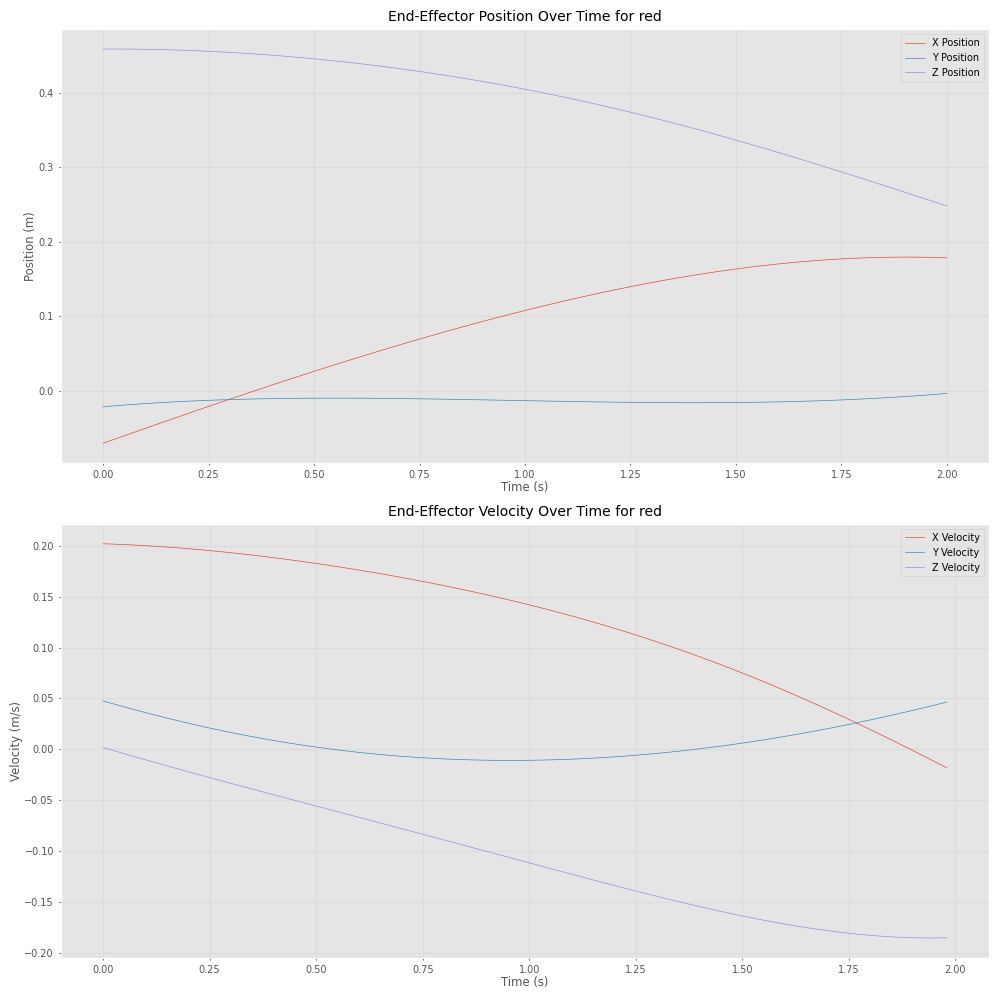

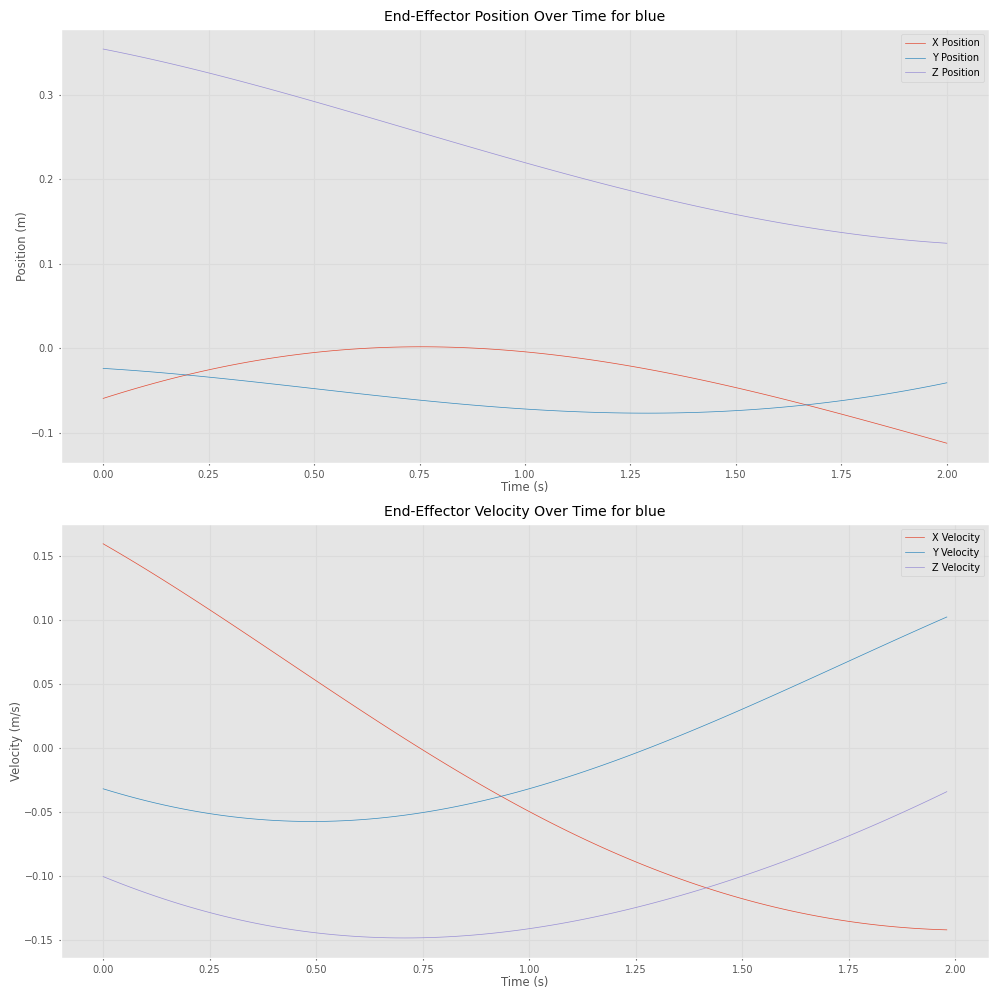

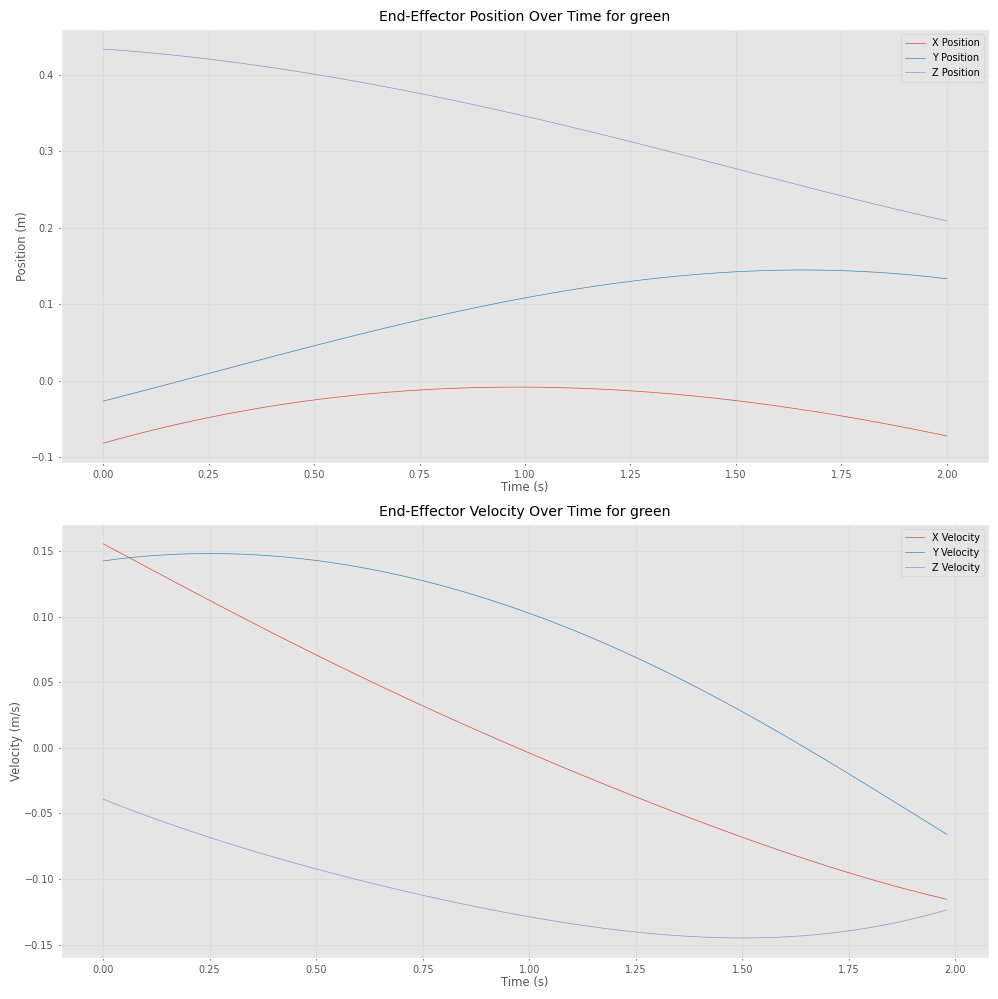

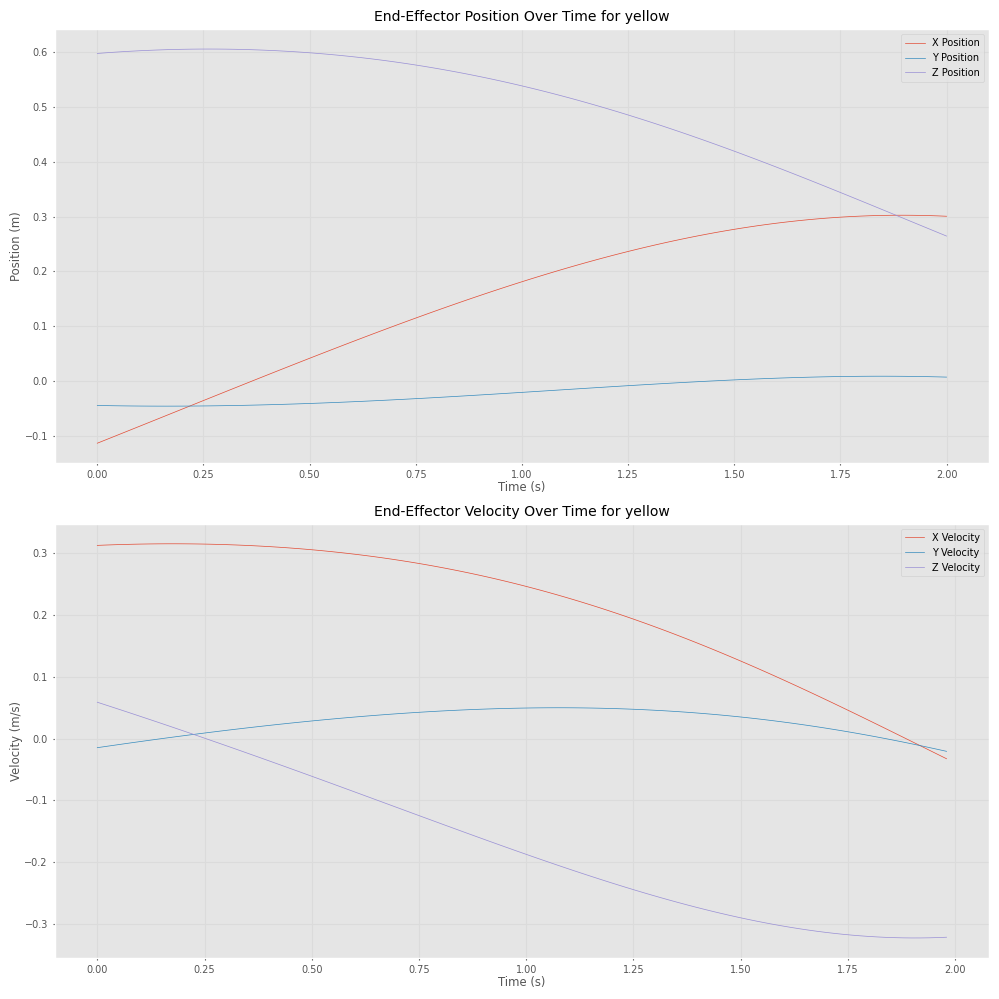

In [15]:
def plot_ee_position_velocity(trajectories, panda):
    """Plot time vs end-effector position and velocity."""
    for name, traj_dict in trajectories.items():
        # Combine all trajectories into one continuous motion
        combined_trajectory = (
            traj_dict["home_to_pick_above"] +
            traj_dict["pick_above_to_pick"] +
            traj_dict["pick_to_pick_above"] +
            traj_dict["pick_above_to_place_abv"] +
            traj_dict["place_abv_to_place"]
        )

        ee_positions = []
        for q in combined_trajectory:
            ee_pose = panda.fkine(q)  # Forward kinematics to get end-effector pose
            ee_positions.append(ee_pose.t)  # Extract translation (x, y, z)

        ee_positions = np.array(ee_positions)
        time_steps = np.linspace(0, len(ee_positions) * 0.02, len(ee_positions))  # Assuming 0.02s per step

        # Compute velocities as differences between consecutive positions
        ee_velocities = np.diff(ee_positions, axis=0) / 0.02  # Velocity = Δposition / Δtime

        # Plot position
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        axs[0].plot(time_steps, ee_positions[:, 0], label="X Position")
        axs[0].plot(time_steps, ee_positions[:, 1], label="Y Position")
        axs[0].plot(time_steps, ee_positions[:, 2], label="Z Position")
        axs[0].set_title(f"End-Effector Position Over Time for {name}")
        axs[0].set_xlabel("Time (s)")
        axs[0].set_ylabel("Position (m)")
        axs[0].legend()
        axs[0].grid(True)

        # Plot velocity
        velocity_time_steps = time_steps[:-1]  # One less due to differentiation
        axs[1].plot(velocity_time_steps, ee_velocities[:, 0], label="X Velocity")
        axs[1].plot(velocity_time_steps, ee_velocities[:, 1], label="Y Velocity")
        axs[1].plot(velocity_time_steps, ee_velocities[:, 2], label="Z Velocity")
        axs[1].set_title(f"End-Effector Velocity Over Time for {name}")
        axs[1].set_xlabel("Time (s)")
        axs[1].set_ylabel("Velocity (m/s)")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

plot_ee_position_velocity(trajectories, panda)

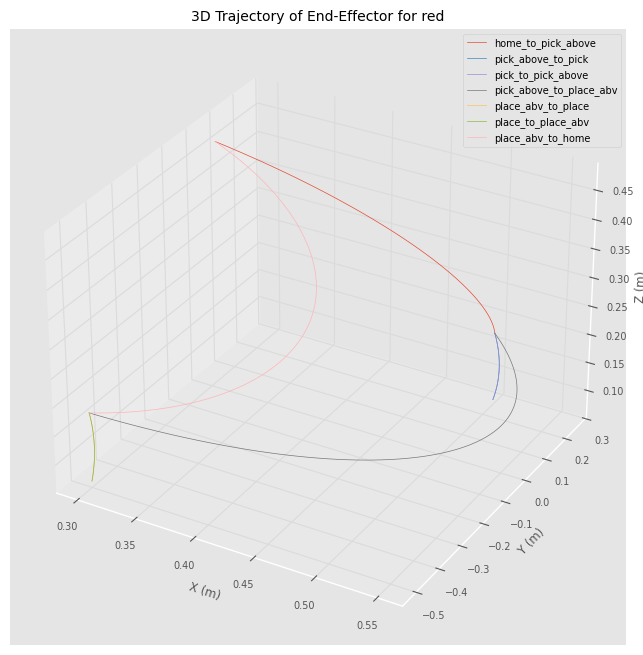

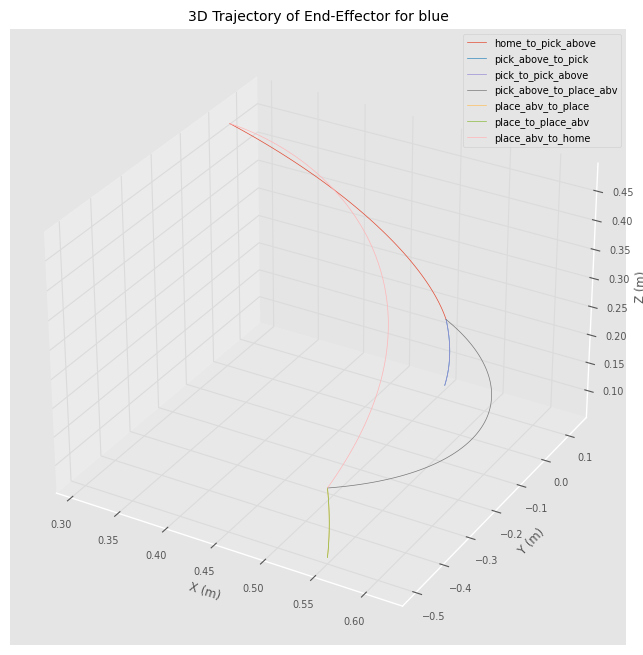

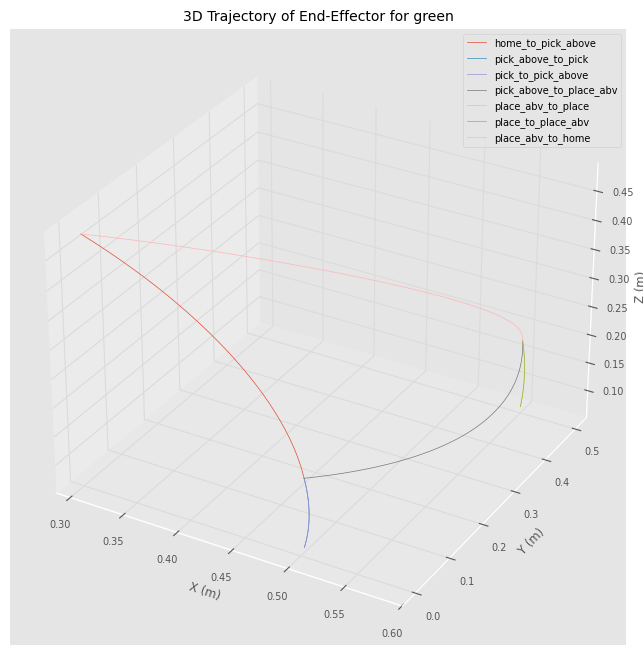

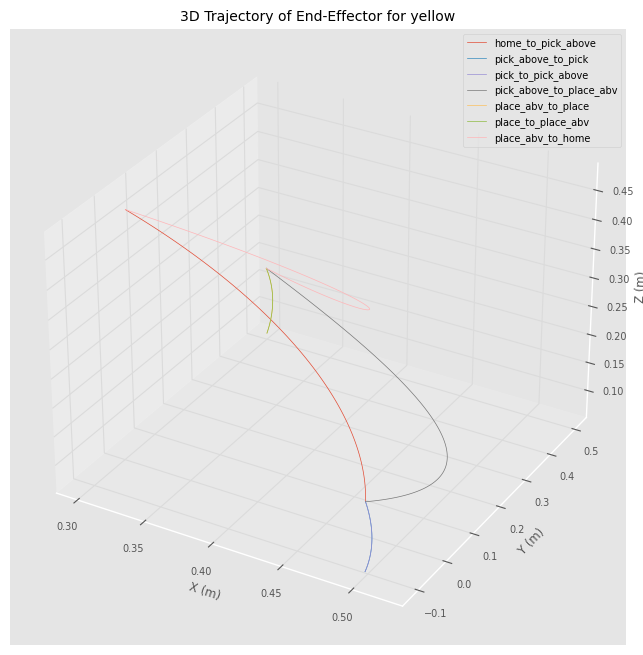

In [16]:
def plot_3d_trajectory_per_cube(trajectories, panda):
    """Plot the 3D trajectory of the robot's end-effector for each cube without combining trajectories."""
    for name, traj_dict in trajectories.items():
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        for phase, traj in traj_dict.items():
            ee_positions = []
            for q in traj:
                ee_pose = panda.fkine(q) 
                ee_positions.append(ee_pose.t) 

            ee_positions = np.array(ee_positions)
            ax.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], label=phase)

        ax.set_title(f"3D Trajectory of End-Effector for {name}")
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.set_zlabel("Z (m)")
        ax.legend()
        plt.show()

plot_3d_trajectory_per_cube(trajectories, panda)

# Auto detection

In [17]:
# def detect_objects_in_scene():
#     """
#     Detect all objects (cubes) currently in the Swift scene
#     by reading their poses and returning their (color, x, y) coordinates
#     """
#     detected_objects = {}
    
#     for name, cube_obj in cube_objs.items():
#         # Get current pose of the cube from Swift
#         pose = cube_obj.T
#         x = pose.t[0]
#         y = pose.t[1]
#         z = pose.t[2]
        
#         detected_objects[name] = {
#             'x': x,
#             'y': y,
#             'z': z,
#             'pose': pose,
#             'detected': True
#         }
        
#         print(f"[VISION] Detected {name:6s} cube at position (x={x:.3f}, y={y:.3f}, z={z:.3f})")
    
#     return detected_objects


# def find_nearest_object(detected_objects):
#     """
#     Find the nearest object to the robot home position
#     """
#     # Robot base approximate position (origin)
#     robot_x, robot_y = 0.0, 0.0
    
#     min_distance = float('inf')
#     nearest_name = None
#     nearest_dist = None
    
#     for name, obj_info in detected_objects.items():
#         # Euclidean distance in XY plane
#         distance = np.sqrt((obj_info['x'] - robot_x)**2 + 
#                           (obj_info['y'] - robot_y)**2)
        
#         if distance < min_distance:
#             min_distance = distance
#             nearest_name = name
#             nearest_dist = distance
    
#     return nearest_name, nearest_dist


# def autonomous_garbage_sorting():
#     """
#     Main autonomous loop:
#     1. Scan environment to detect all objects
#     2. Pick nearest object
#     3. Repeat until all objects are sorted
#     """
#     print("\n" + "="*60)
#     print("[ROBOT] Starting autonomous garbage sorting...")
#     print("="*60 + "\n")
    
#     # Step 1: Initial scan
#     print("[VISION] Scanning environment for objects...\n")
#     detected = detect_objects_in_scene()
    
#     if not detected:
#         print("[ERROR] No objects detected in scene")
#         return
    
#     print(f"\n[INFO] Total objects found: {len(detected)}\n")
    
#     # Step 2: Sort objects one by one (nearest first)
#     remaining = set(detected.keys())
#     sorted_count = 0
    
#     while remaining:
#         print("-" * 60)
        
#         # Find nearest among remaining objects
#         nearest_name, distance = find_nearest_object(
#             {k: v for k, v in detected.items() if k in remaining}
#         )
        
#         print(f"\n[SEARCH] Nearest object: {nearest_name.upper()}")
#         print(f"[SEARCH] Distance from robot: {distance:.3f}m")
#         print(f"[SEARCH] Coordinates: x={detected[nearest_name]['x']:.3f}, "
#               f"y={detected[nearest_name]['y']:.3f}")
        
#         # Pick and place this object
#         print(f"\n[ACTION] Executing pick-and-place for {nearest_name}...\n")
#         execute_pick_and_place(nearest_name, sleep_dt=0.01)
        
#         # Mark as sorted
#         remaining.remove(nearest_name)
#         sorted_count += 1
        
#         print(f"\n[SUCCESS] {nearest_name.upper()} cube sorted!")
#         print(f"[PROGRESS] {sorted_count}/{len(detected)} objects sorted")
#         print(f"[REMAINING] {len(remaining)} objects left")
    
#     print("\n" + "="*60)
#     print("[COMPLETE] Autonomous garbage sorting finished successfully!")
#     print("="*60 + "\n")
